## <center>1. Getting Started </center>

In [1]:
import os
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
%config IPCompleter.greedy=True

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [3]:
%%html
<style> 
table td, table th, table tr {text-align:center !important;}
</style>

## <center>2. Data Loader</center>
##### 1.

In [4]:
dataset_root_dir = "/datasets/ee285f-public/caltech_ucsd_birds/"

##### 2.

In [5]:
class BirdsDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224)): 
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode)) 
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
                                    format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                    self.data.iloc[idx]['file_path']) 
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]) ]) # (img - mean) / std -> min:-1 ; max:1
        x = transform(img)
        d = self.data.iloc[idx]['class'] 
        return x, d
    
    def number_of_classes(self):
        return self.data['class'].max() + 1

##### 3. Function of image displaying

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

##### Create object

In [7]:
train_set = BirdsDataset(dataset_root_dir, mode="train", image_size=(224, 224))

##### Sample element

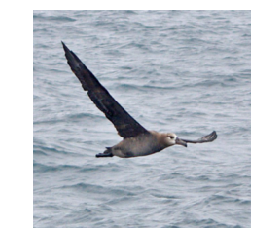

In [8]:
x = train_set.__getitem__(idx = 10)[0]
h = myimshow(x, ax=plt)

##### 4.

In [9]:
train_loader = td.DataLoader(train_set, 
                             batch_size = 16, 
                             shuffle = True, 
                             pin_memory = True)
print("Number of mini-batches are %s" %len(train_loader))

Number of mini-batches are 47


>### CONCLUSION
>##### 1. Advantage of using **pin_memory**
1). The data loader will copy tensors into CUDA pinned memory before returning them, which will make the data loading and processing very fast.<br>
2). Higher bandwidth is possible between the host and the device when using pinned memory.
>
>##### 2. Number of mini-batches
1). Mathematically, the number of mini-batches are $floor(743/16) = 47$<br>
2). The result by checking the train_loader is in accordance.

##### 5. Display the first image and label pair of the first 4 mini-batches

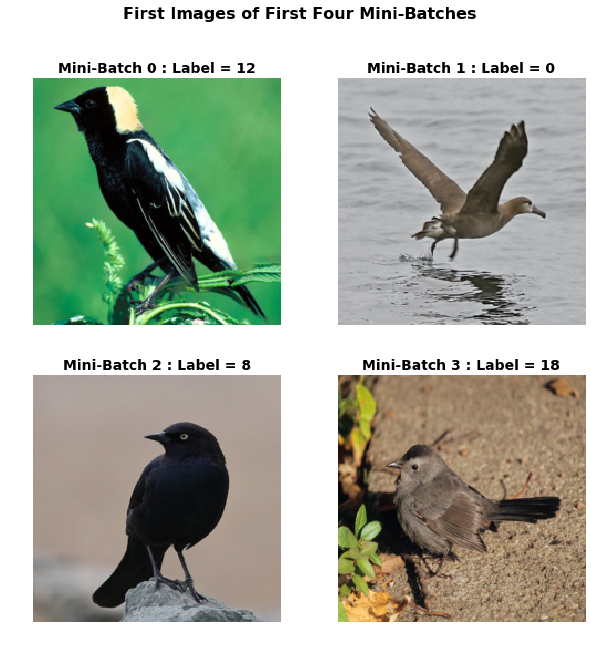

In [10]:
sp_num = 221
plt.figure(1, figsize = (10,10))
plt.suptitle("First Images of First Four Mini-Batches", weight = "bold", fontsize = 16)
for mini_batches in list(enumerate(train_loader))[:4]:
    ind, (img, idx) = mini_batches
    plt.subplot(sp_num)
    sp_num += 1
    plt.title("Mini-Batch {0} : Label = {1}".format(ind, idx[0]), weight = "bold", fontsize = 14)
    h = myimshow(img[0], ax=plt)

>### CONCLUSION
>##### 1. Changes brought by shuffling
Although we implement the displaying of image, label pair in a different cell, we get different four pairs every time when we reevaluate the cell. This is how DataLoader with shuflling works, we are able to pick new examples every time since the mini-batches will always get shuffled.

##### 6. Validation set

In [11]:
val_set = BirdsDataset(dataset_root_dir, mode="val", image_size=(224, 224))
val_num_cls = val_set.number_of_classes()
val_loader = td.DataLoader(val_set, 
                           batch_size = 16, 
                           shuffle = False, 
                           pin_memory = True)

>### CONCLUSION
>##### 1. Why we need shuffling in train set
It is because fo the nature of mini-batch gradient descent, which is a trade-off between stochastic gradient descent and batch gradient descent. In mini-batch gradient descent, we pick a small size of mini-batch of training exampels to keep the fast convergence speed of SGD. That is to say, mini-batch learning relies on the randomness to find a minima, which indicates that shuffling the mini-batches every epoch makes the gradients more variable and thus help convergence because it increases the likelihood of hitting a good direction.
>
>##### 2. Why we do **NOT** need shuffling in validation set
Firstly, we create validation set for testing the performance of training and preventing overfitting as well. In this case, only if we keep the criterion/standard (i.e.: same validation set with the same examples) for testing remains the same can we truly tell whether the performance is improved or not. Otherwise, the randomness triggered by the shuffling of validations set will greatly affect our evaluation

## <center>3. Abstract Neural Network Model</center>
##### 7. Instantiate a neural network

In [12]:
import nntools as nt

In [13]:
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

>### CONCLUSION
>##### Failure of instantiating the neural network by $net = nt.NeuralNetwork()$
1) **Reported reason**: 'Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward'
2) **Explanation**: An abstract class does not implement all of its methods and cannot be instantiated. This is because the implementation of __forward__ and __criterion__ will depend on the specific type and architecture of neural networks we will be considering. The implementation of these two methods will be done in sub-classes following the principle of inheritance.

##### Define the subclass NNClassifier that inherits from NeuralNetwork and implements the method criterion as being the cross entropy loss

In [14]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

## <center>4. VGG-16 Transfer Learning</center>
##### 8. Run the following

In [15]:
vgg = tv.models.vgg16_bn(pretrained = True)

##### Print the network and inspect its learnable parameters (as done in Assignment 2).

In [16]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

>### CONCLUSION
|__Learnable Parameters__|features|classifiers|
|---|---|---|
|__Index__|$0-43$|$0-6$|
|__Layers__|Conv2d<br>BatchNorm2d<br>ReLU<br>MaxPool2d|Linear<br>ReLU<br>Dropout<br>linear|
>
>##### The learnable paramters are divided into 2 parts:
1. **features**: convolution, batch normalization, ReLU activation, max pooling
2. **classifiers**: linear, ReLU non-linearity, dropout, linear

##### 9.

In [17]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning = False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained = True) 
        for param in vgg.parameters():
            param.requires_grad = fine_tuning 
            self.features = vgg.features
            self.classifier = vgg.classifier
            num_ftrs = vgg.classifier[6].in_features
            self.classifier[6] = nn.Linear(num_ftrs, num_classes)
    def forward(self, x): 
        f = self.features(x)
        f = f.view(-1, np.prod(f.size()[1:]))
        y = self.classifier(f) 
        return y

## <center> 5. Training experiment and checkpoints </center>

##### 10. Create an instance of this class for a classification problem with a number of classes specified

In [18]:
num_classes = train_set.number_of_classes()
v = VGG16Transfer(num_classes, fine_tuning = False)

In [19]:
print(v)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

>### CONCLUSION
|__Learnable Parameters__|cross_entropy|features|classifiers|
|---|---|---|---|
|__Index__|NA|$0-43$|$0-6$|
|__Layers__|Cross entropy loss function|Conv2d<br>BatchNorm2d<br>ReLU<br>MaxPool2d|Linear<br>ReLU<br>Dropout<br>linear|
>
>##### The learnable paramters are divided into 2 parts:
1. **cross_entropy**: cross entropy loss
2. **features**: convolution, batch normalization, ReLU activation, max pooling
3. **classifiers**: linear, ReLU non-linearity, dropout, linear

##### 11. Create a new subclass ClassificationStatsManager that inherits from StatsManager

In [20]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
    def accumulate(self, loss, x, y, d): 
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d) 
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize() 
        accuracy = 100 * self.running_accuracy 
        return {'loss': loss, 'accuracy': accuracy}

##### 12. 

>### CONCLUSION
>##### Reason of using *evaluate* mode
1. Dropout and BatchNorm behave differently during training and evaluation. We must let the model know when to switch to eval mode by calling **.eval( )** on the model.<br>
2. **eval** mode sets self.training to False for every module in the model. If you are implementing your own module that must behave differently during training and evaluation, you can check the value of self.training while doing so.

##### 13.

In [21]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training = True)

##### Check the existence of directory

In [22]:
print("The directory named 'birdclass1' exists: {0}".format(os.path.isdir("birdclass1")))

The directory named 'birdclass1' exists: True


##### Visualize the config.txt

In [23]:
with open("birdclass1/config.txt","r") as f:
    config = f.read()
print(config)

Net(VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

##### checkpoint.pth.tar

In [24]:
model = torch.load("birdclass1/checkpoint.pth.tar")
print(type(model))

<class 'dict'>


>### CONCLUSION
>##### checkpoint.pth.tar
The checkpoints w.r.t to the learnable parameters of neural network are organzied in the dictionary and further saved in the file with the extension of 'tar'

##### 14.  Change learning rate

In [25]:
lr = 1e-4
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr = lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

>### CONCLUSION
>##### Failure of re-implementation after changing new learning rate
1) **Reported reason**: 'Cannot create this experiment: I found a checkpoint conflicting with the current setting'
2) **Explanation**: We have already saved that checkpoint with the setting of learning rate $\eta = 10^-3$ and will not be allowed to create a new setting upon that. To make this happen we can change directory from 'birdclass1' to others for a new setting 

##### Change learning rate back

In [26]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

>### CONCLUSION
>##### Success of re-implementation after changing new learning rate
**Explanation**: As what was discussed before, we have already saved the checkpoint with the setting of learning rate $\eta = 10^-3$ and the command above alignes with the setting. As long as our new command with the settting in accordance with the one for the checkpoints created and saved, we can still implement and re-evaluate for as many times as we want.

##### 15. 20 epochs

##### For convenience, I made small modification to the plot function

In [27]:
def plot(exp, fig, axes): 
    plt.suptitle(title, weight = "bold")
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label = "training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label = "evaluation loss")
    axes[0].set_title("loss")
    axes[0].legend()
    axes[1].plot([exp.history[k][0]['accuracy']/len(train_loader) for k in range(exp.epoch)],
                label = "training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy']/len(val_loader) for k in range(exp.epoch)],
                 label = "evaluation accuracy")
    axes[1].set_title("accuracy")
    axes[1].legend()
    plt.tight_layout()
    fig.canvas.draw()

Start/Continue training from epoch 0
Epoch 1 (Time: 20.48s)
Epoch 2 (Time: 24.33s)
Epoch 3 (Time: 24.98s)
Epoch 4 (Time: 24.15s)
Epoch 5 (Time: 24.80s)
Epoch 6 (Time: 24.43s)
Epoch 7 (Time: 24.33s)
Epoch 8 (Time: 24.73s)
Epoch 9 (Time: 24.43s)
Epoch 10 (Time: 24.59s)
Epoch 11 (Time: 24.84s)
Epoch 12 (Time: 24.75s)
Epoch 13 (Time: 25.20s)
Epoch 14 (Time: 24.92s)
Epoch 15 (Time: 23.88s)
Epoch 16 (Time: 24.36s)
Epoch 17 (Time: 24.44s)
Epoch 18 (Time: 24.25s)
Epoch 19 (Time: 24.86s)
Epoch 20 (Time: 24.70s)
Finish training for 20 epochs


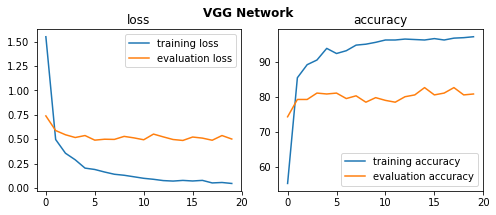

In [28]:
title = "VGG Network"
fig, axes = plt.subplots(ncols = 2, figsize = (7, 3))
exp1.run(num_epochs = 20, plot = lambda exp: plot(exp, fig = fig, axes = axes))

## <center>6.ResNet18 Transfer Learning </center>
##### 16. Create a subclass Resnet18Transfer that inherits from NNClassifer and that redefines the last FC layer.

In [29]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning = False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained = True) 
        for param in resnet.parameters():
            param.requires_grad = fine_tuning 
            self.conv1 = resnet.conv1
            self.bn1 = resnet.bn1
            self.relu = resnet.relu
            self.maxpool = resnet.maxpool
            self.layer1 = resnet.layer1
            self.layer2 = resnet.layer2
            self.layer3 = resnet.layer3
            self.layer4 = resnet.layer4
            self.avgpool = resnet.avgpool

            num_ftrs = resnet.fc.in_features
            self.fc = nn.Linear(num_ftrs, num_classes)
    def forward(self, x): 
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(-1, np.prod(out.size()[1:]))
        y = self.fc(out)
        return y

##### 17. Create an instance of Resnet18Transfer and create a new experiment exp2 making backups in the directory birdclass2. Run the experiment for 20 epochs with Adam and learning rate 1e-3 using the same function plot as before.

In [30]:
lr = 1e-3
net = Resnet18Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr = lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass2", perform_validation_during_training = True)

Start/Continue training from epoch 0
Epoch 1 (Time: 21.63s)
Epoch 2 (Time: 21.88s)
Epoch 3 (Time: 21.54s)
Epoch 4 (Time: 21.59s)
Epoch 5 (Time: 21.52s)
Epoch 6 (Time: 21.47s)
Epoch 7 (Time: 21.39s)
Epoch 8 (Time: 21.60s)
Epoch 9 (Time: 21.30s)
Epoch 10 (Time: 21.65s)
Epoch 11 (Time: 21.79s)
Epoch 12 (Time: 21.34s)
Epoch 13 (Time: 21.64s)
Epoch 14 (Time: 21.72s)
Epoch 15 (Time: 21.56s)
Epoch 16 (Time: 21.65s)
Epoch 17 (Time: 21.66s)
Epoch 18 (Time: 21.48s)
Epoch 19 (Time: 21.68s)
Epoch 20 (Time: 21.63s)
Finish training for 20 epochs


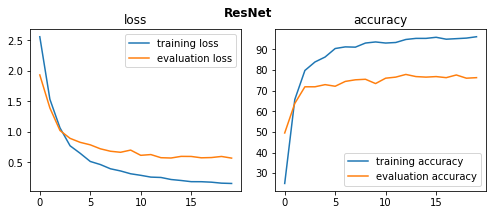

In [31]:
title = "ResNet"
fig, axes = plt.subplots(ncols = 2, figsize = (7, 3))
exp2.run(num_epochs = 20, plot = lambda exp: plot(exp, fig = fig, axes = axes))

##### 18. Using the method evaluate of Experiment, compare the validation performance obtained by exp1 and exp2 using respectively VGG16Transfer and Resnet18Transfer.

In [32]:
eval1,eval2 = exp1.evaluate(),exp2.evaluate()
print("VGG Network:\nloss: {0}\naccuracy:{1}".format(eval1["loss"],eval1["accuracy"]/len(val_loader)))
print("ResNet:\nloss: {0}\naccuracy:{1}".format(eval2["loss"],eval2["accuracy"]/len(val_loader)))


VGG Network:
loss: 0.5019242152895617
accuracy:80.72917175292969
ResNet:
loss: 0.5715907501137775
accuracy:76.30208587646484
